### Dataset loader for the deep learning model training.

In [ ]:
import torch
import random
import time
import numpy as np 
from glob import glob
import rasterio as rio 
from notebooks import config
from utils.imgShow import imsShow 


In [ ]:
### secene and truth pairwise data
# ## traset
paths_scene_tra, paths_dem_tra, paths_truth_tra = config.paths_scene_tra, config.paths_dem_tra, config.paths_truth_tra
print(f'train scenes: {len(paths_scene_tra)}')
## valset
paths_patch_valset = sorted(glob('data/dset/valset/patch_512/*'))
print(f'vali patch: {len(paths_patch_valset)}')


train scenes: 48
vali patch: 275


In [3]:
## create related functions
## - crop scene to patches
class RandomCrop:
    '''
    des: randomly crop corresponding to specific patch size
    '''
    def __init__(self, size=(256, 256)):
        self.size = size
    def __call__(self, image, truth):
        '''
        args:
            image: np.array, shape: (C, H, W)
            truth: np.array, shape: (H, W)
        '''
        start_h = random.randint(0, truth.shape[0]-self.size[0])
        start_w = random.randint(0, truth.shape[1]-self.size[1])
        patch = image[:,start_h:start_h+self.size[0],start_w:start_w+self.size[1]]
        truth = truth[start_h:start_h+self.size[0], start_w:start_w+self.size[1]]
        return patch, truth


In [ ]:
### - Dataset definition
class ScenePathSet(torch.utils.data.Dataset):
    '''
    des: build dataset using file paths
    '''
    def __init__(self, paths_scene, paths_truth, paths_dem=None, path_size=(512, 512)):
        self.paths_scene = paths_scene
        self.paths_truth = paths_truth
        self.paths_dem = paths_dem
        self.path_size = path_size
    def __getitem__(self, idx):
        # Load scene and truth image
        scene_path = self.paths_scene[idx]
        truth_path = self.paths_truth[idx]
        ## 1. read scene and truth images
        with rio.open(scene_path) as src:
            scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
        with rio.open(truth_path) as truth_src:
            truth_arr = truth_src.read(1)  # (H, W)
        ## 2. read dem
        if self.paths_dem is not None:
            dem_path = self.paths_dem[idx]
            with rio.open(dem_path) as dem_src:
                dem_arr = dem_src.read(1)  # (H, W)
            dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
            scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1)  # (H, W, C+1)
        ## post processing
        scene_arr = scene_arr.astype(np.float32).transpose((2, 0, 1)) # (C, H, W)
        patch, truth = RandomCrop(size=self.path_size)(scene_arr, truth_arr)  # crop
        truth = truth[np.newaxis, :].astype(np.int8)  # (C, H, W)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).float()
        return patch, truth
    def __len__(self):
        return len(self.paths_scene)

### - Dataset definition
class SceneArraySet(torch.utils.data.Dataset):
    def __init__(self, scenes_arr, truths_arr, dems_arr=None, path_size=(512, 512)):
        '''
        des: build dataset using pre-loaded arrays
        args:
            scenes_arr: list of np.arrays, each array is (H, W, C) 
            truths_arr: list of np.arrays, each array is (H, W)
            dems_arr: list of np.arrays, each array is (H, W), optional
            path_size: tuple, (height, width) of cropped patch
        '''
        self.scenes_arr = scenes_arr
        self.truths_arr = truths_arr
        self.dems_arr = dems_arr
        self.path_size = path_size
    def __getitem__(self, idx):
        scene_arr = self.scenes_arr[idx].astype(np.float32).transpose((2, 0, 1)) # (C, H, W)
        truth_arr = self.truths_arr[idx]
        patch, truth = RandomCrop(size=self.path_size)(scene_arr, truth_arr)  # crop
        truth = truth[np.newaxis, :].astype(np.int8)  # (C, H, W)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).float()
        return patch, truth
    def __len__(self):
        return len(self.scenes_arr)

### - Dataset definition
class PatchPathSet(torch.utils.data.Dataset):
    def __init__(self, paths_valset):
        self.paths_valset = paths_valset
    def __getitem__(self, idx):
        ## load valset patch, patch: (H, W, C)
        patch_ptruth = torch.load(self.paths_valset[idx], weights_only=True) 
        patch_ptruth = patch_ptruth.permute(2,0,1)  # (C, H, W)
        return patch_ptruth[0:-1], patch_ptruth[-1:]
    def __len__(self):
        return len(self.paths_valset)



In [5]:
def read_scenes(scene_paths, truth_paths, dem_paths):
  paths_zip = zip(scene_paths, truth_paths, dem_paths)
  scenes_arr = []
  truths_arr = []
  for scene_path, truth_path, dem_path in paths_zip:
      ## 1. read scene and truth images
      with rio.open(scene_path) as src:
          scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
      with rio.open(truth_path) as truth_src:
          truth_arr = truth_src.read(1)  # (H, W)
      ## 2. read dem
      with rio.open(dem_path) as dem_src:
          dem_arr = dem_src.read(1)  # (H, W)
      dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
      scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1)  # (H, W, C+1)
      scenes_arr.append(scene_arr)
      truths_arr.append(truth_arr)
  return scenes_arr, truths_arr

scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra)


In [ ]:
# Create dataset instances
# tra_data = ScenePathSet(paths_scene=list(paths_scene_tra), 
#                    paths_truth=list(paths_truth_tra), 
#                    paths_dem=list(paths_dem_tra),
#                    path_size=(512, 512)
#                    )
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         path_size=(512, 512))
val_data = PatchPathSet(paths_valset=list(paths_patch_valset)) 


torch.Size([7, 512, 512]) torch.Size([1, 512, 512])
training data size: 48
validation data size: 275


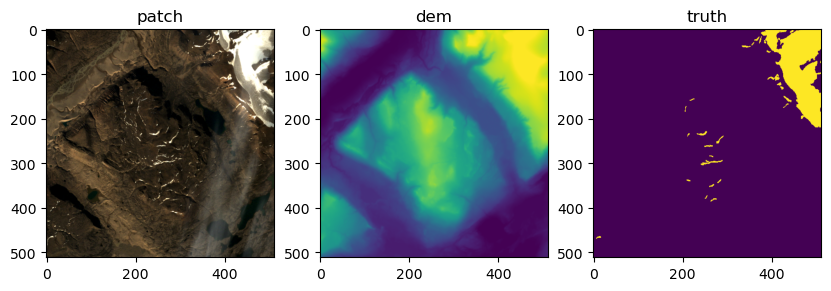

In [7]:
patch_pdem, ptruth = tra_data[0]
scene, dem = patch_pdem[:-1], patch_pdem[-1]  # last channel is dem
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([scene.numpy().astype(float).transpose((1, 2, 0)), dem.numpy(), ptruth[0].numpy()], 
              clip_list=[2,2,2], img_name_list=['patch','dem','truth'], figsize=(10, 3))


In [16]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


In [17]:
## check data loading time
time_start = time.time()
for x_batch, y_batch in tra_loader:
  print(f"traBatch processing time: {time.time() - time_start:.1f}")
time_start = time.time()  

# ## check data loading time
# time_start = time.time()
# for x_batch, y_batch in val_loader:
#   print(f"valBatch processing time: {time.time() - time_start:.1f}")
# time_start = time.time()   


traBatch processing time: 0.8
traBatch processing time: 0.8
traBatch processing time: 0.8
traBatch processing time: 0.8
traBatch processing time: 0.8
traBatch processing time: 0.8
traBatch processing time: 1.1
traBatch processing time: 1.1
traBatch processing time: 1.1
traBatch processing time: 1.3
traBatch processing time: 1.3
traBatch processing time: 1.3


torch.Size([4, 7, 512, 512]) torch.Size([4, 1, 512, 512])


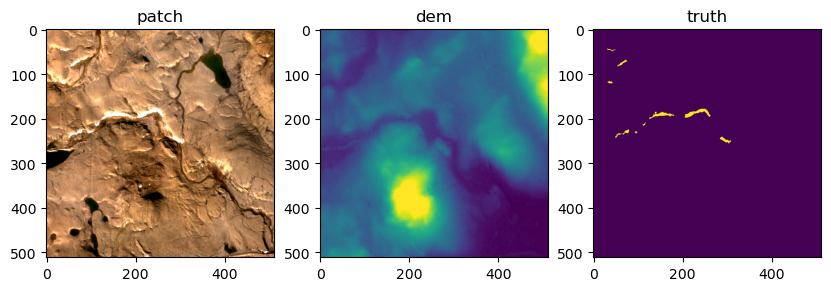

In [49]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
dem_arr = batch_patch[0].numpy()[-1]
truth_arr = batch_truth[0].numpy().squeeze()
imsShow([patch_arr,  dem_arr, truth_arr],  
          color_bands_list=[[2,1,0], None, None],
          img_name_list=['patch', 'dem', 'truth'], 
          clip_list=[2,2,2], 
          figsize=(10, 3))
